#Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.io
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ipywidgets import Button, Label, FileUpload
from ipywidgets import FileUpload, Label
import warnings
warnings.filterwarnings('ignore')

#Importación de imágenes y primeros filtros

Es notorio que la base de datos cuenta con demasiado ruido (las rocas a su alrededor) se aplicarán filtros para eliminar el ruido, resaltar el contorno y el color verde de las imágenes

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/Diplomado/Modulo VI/Proyecto 2/plants'

In [4]:
target_size = (150, 150)
batch_size = 36
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Diplomado/Modulo VI/Proyecto 2/plants',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5539 images belonging to 12 classes.


In [5]:
def apply_filters_and_convolutions(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Bordes en RGB
    sobel_x = cv2.Sobel(image[:, :, 0], cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image[:, :, 0], cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

    # Filtro de convolución
    kernel = np.array([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]])
    custom_convolution = cv2.filter2D(image, -1, kernel)
    return image, blurred_image, sobel_combined, custom_convolution

In [6]:
images, _ = next(train_generator)
processed_images = []
for img in images:
    image, blurred_image, sobel_combined, custom_convolution = apply_filters_and_convolutions(img)
    processed_images.append(custom_convolution)

##Salida

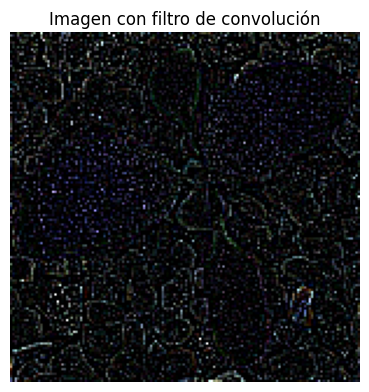

In [7]:
def display_images(images, titles):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()
display_images([processed_images[0]], ['Imagen con filtro de convolución'])

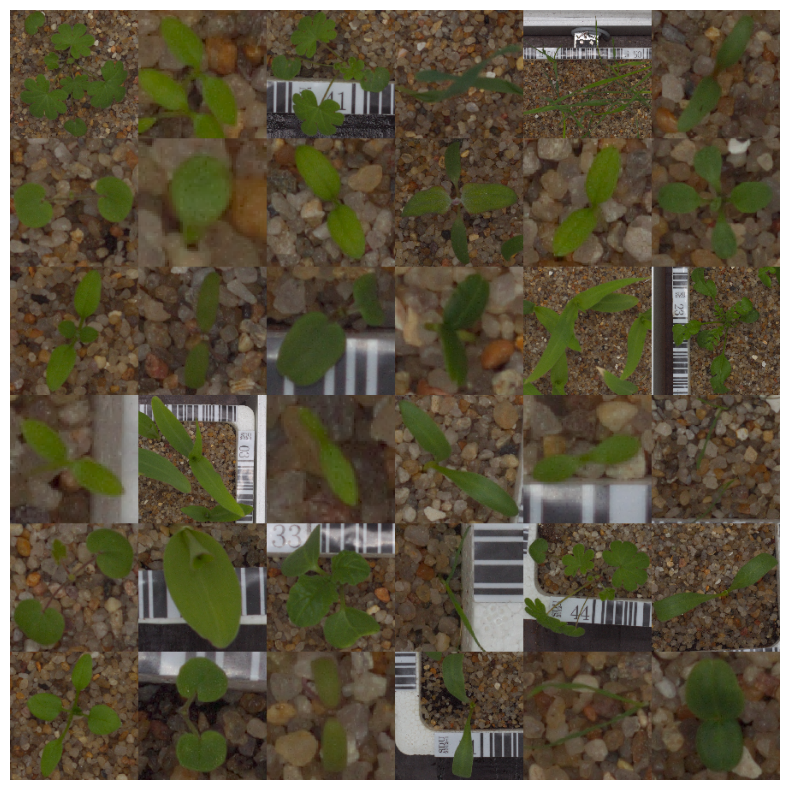

In [8]:
images, _ = next(train_generator)
n, m = target_size
rows, cols = 6, 6
all_images = np.zeros((n*rows, m*cols, 3))

count = 0
for i in range(rows):
    for j in range(cols):
        all_images[i*n : (i+1)*n, j*m : (j+1)*m, :] = images[count]
        count += 1

plt.figure(figsize=(10, 10))
plt.imshow(all_images)
plt.axis('off')
plt.show()

#Modelo CNN

##Arquitectura del modelo

In [9]:
model = keras.Sequential([
    # Capa 1
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Capa 2
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Capa 3
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Aplanamiento
    layers.Flatten(),

    # Capa densa
    layers.Dense(128, activation='relu'),

    # Dropout
    layers.Dropout(0.3),

    # Capa de salida
    layers.Dense(12, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,900 (18.42 MB)

 Trainable params: 4,829,900 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

##Entrenamiento del modelo

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)


train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Diplomado/Modulo VI/Proyecto 2/plants',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Diplomado/Modulo VI/Proyecto 2/plants',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4991 images belonging to 12 classes.
Found 548 images belonging to 12 classes.


In [20]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.7822 - loss: 0.6324 - val_accuracy: 0.6967 - val_loss: 0.9991
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.8125 - loss: 0.6185 - val_accuracy: 0.7059 - val_loss: 0.9781
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.7990 - loss: 0.5671 - val_accuracy: 0.6636 - val_loss: 1.1921
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.8750 - loss: 0.4353 - val_accuracy: 0.6746 - val_loss: 1.1220
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.8276 - loss: 0.4742 - val_accuracy: 0.7298 - val_loss: 0.8642
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.6250 - loss: 1.0016 - val_accuracy: 0.7298 - val_loss: 0.8680
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.8569 - loss: 0.4069 - val_accuracy: 0.6636 - val_loss: 1.0561
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.8438 - loss: 0.4268 - val_

##Evaluación del modelo

In [21]:
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=0)
print(f'\nPrecisión en validación: {test_accuracy:.4f}')


Precisión en validación: 0.7281


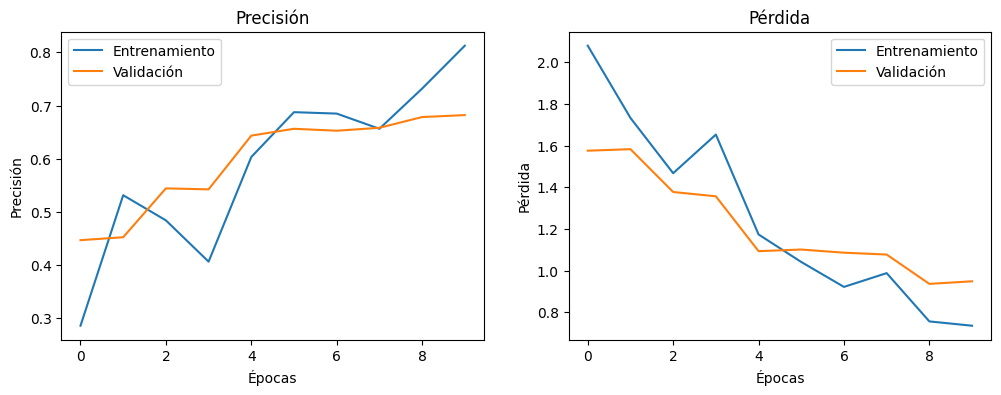

In [14]:
plt.figure(figsize=(12,4))

# Precisión
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


##Predicciones

In [15]:
print("Índices de clases:")
for class_name, index in train_generator.class_indices.items():
    print(f"{index}: {class_name}")

Índices de clases:
0: Black-grass
1: Charlock
2: Cleavers
3: Common Chickweed
4: Common wheat
5: Fat Hen
6: Loose Silky-bent
7: Maize
8: Scentless Mayweed
9: ShepherdÔÇÖs Purse
10: Small-flowered Cranesbill
11: Sugar beet


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


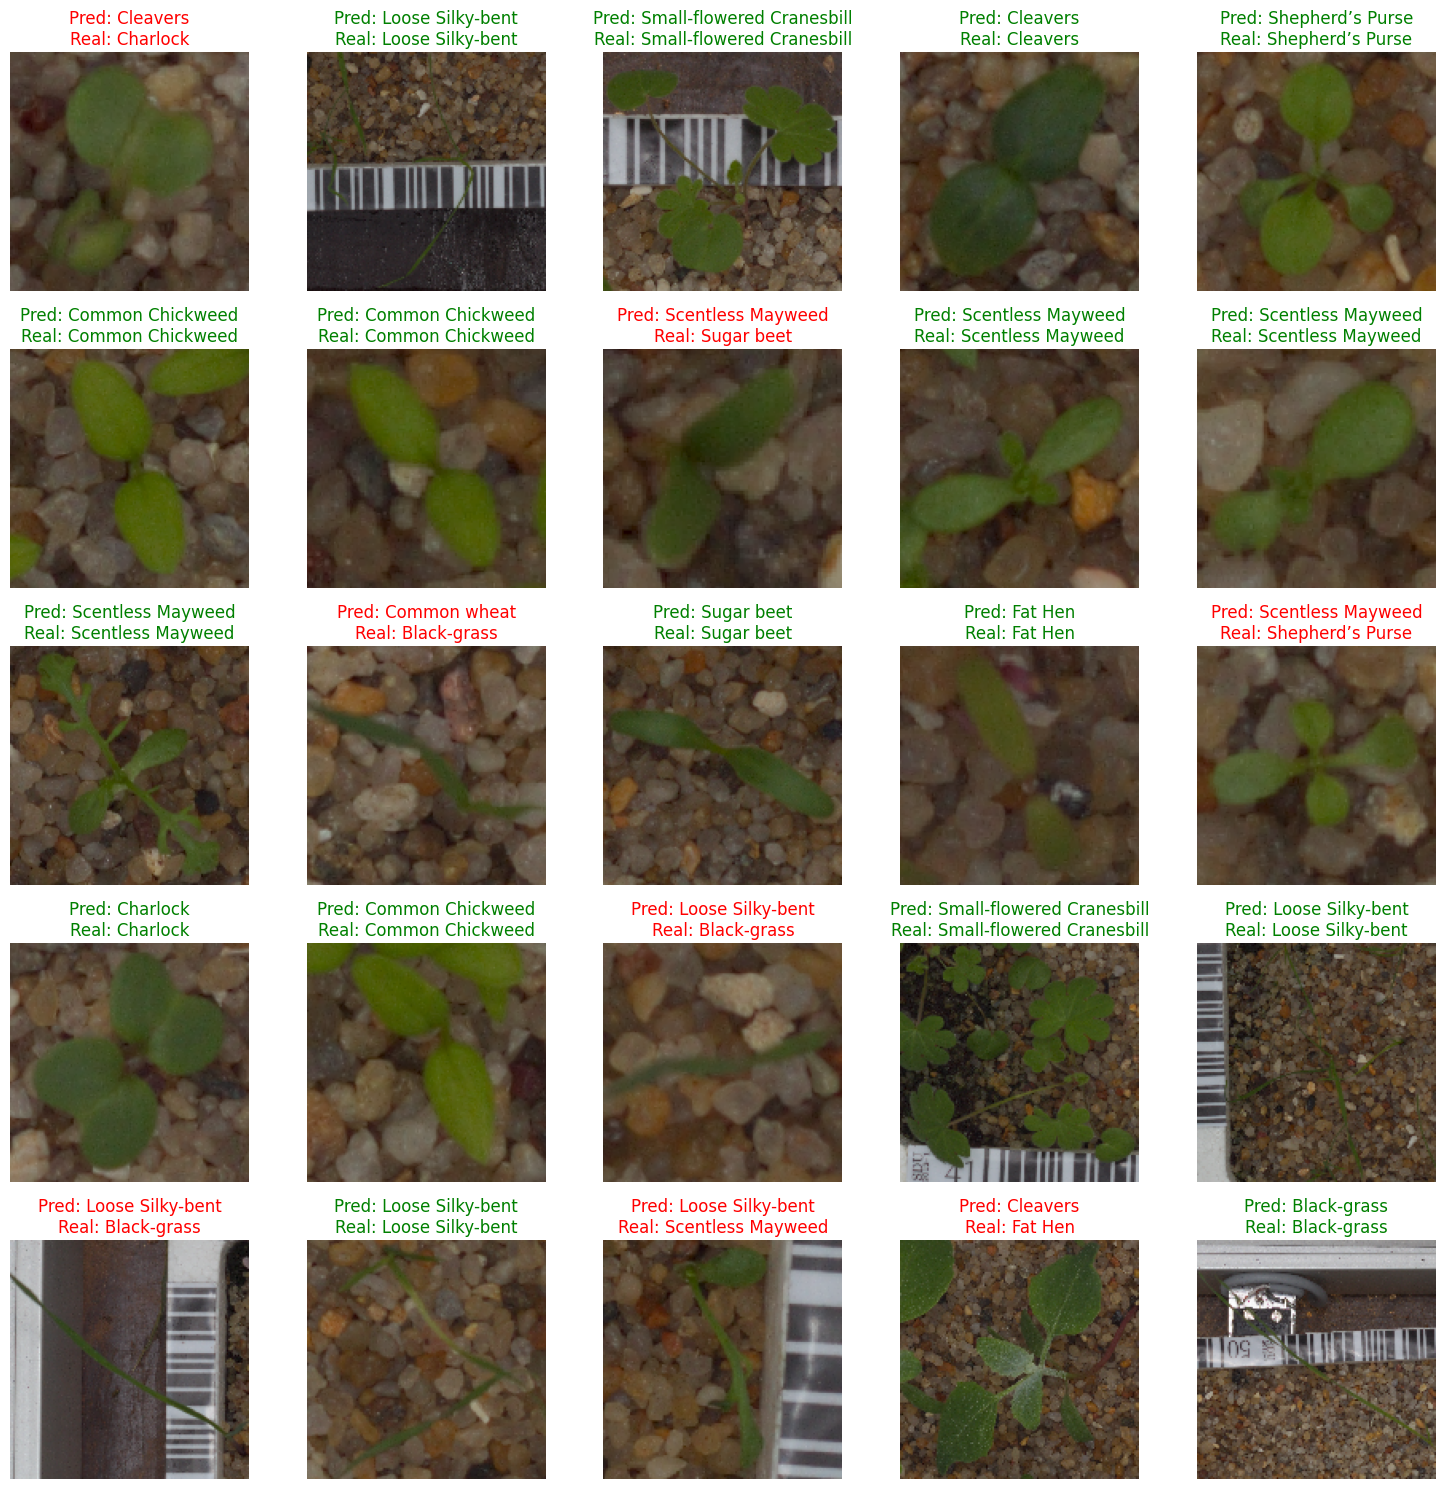

In [16]:
validation_generator.reset()

#Primer batch
val_images, val_labels = next(validation_generator)

#Predicciones
predictions = model.predict(val_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(val_labels, axis=1)
class_names = [
    'Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
    'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
    'Scentless Mayweed', 'Shepherd’s Purse',
    'Small-flowered Cranesbill', 'Sugar beet'
]

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(val_images[i])
    pred_name = class_names[predicted_labels[i]]
    real_name = class_names[true_labels[i]]
    color = 'green' if predicted_labels[i] == true_labels[i] else 'red'
    plt.title(f'Pred: {pred_name}\nReal: {real_name}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

#Interfaz de procesamiento de prueba

In [17]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00


In [22]:
import gradio as gr
class_names = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
               'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
               'Scentless Mayweed', "Shepherd's Purse", 'Small-flowered Cranesbill', 'Sugar beet']

def predict_plant(image):
    img_resized = cv2.resize(image, (150, 150))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)

    # Normalizar
    img_array = img_rgb.astype('float32') / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    # Predicción
    predictions = model.predict(img_input)
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index]

    return f"Clase predicha: {predicted_class} (confianza: {confidence:.2%})"

#Interfaz
interface = gr.Interface(
    fn=predict_plant,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Clasificador de Plantas",
    description="Sube una imagen de una planta."
)
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0e7f5485a28f8fc103.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#Conclusiones
El modelo CNN implementado constó de tres capas convolucionales con funciones de activación ReLU, seguidas de capas de pooling para reducción de dimensionalidad. Posteriormente, se añadió una capa Flatten y dos capas densas, una de ellas con Dropout para evitar el sobreajuste. La capa de salida cuenta con 12 neuronas, correspondientes a las 12 clases de plantas del dataset.


Tras el entrenamiento, el modelo alcanzó una precisión de validación del 72.81%, lo que se puede considerar un resultado aceptable dado que se trabajó con imágenes reales. La arquitectura demostró ser capaz de capturar patrones visuales relevantes y generalizar en un conjunto de validación.


En general, el proyecto permitió aplicar conocimientos clave de visión por computadora, preprocesamiento de imágenes y aprendizaje profundo.
